**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('~/Проект_1_Задание_2.csv', sep=";")
df.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [4]:
control = df.query('testgroup == "a"')
control

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [5]:
test = df.query('testgroup == "b"')
test

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


Рассчитаем ARPU в каждой группе. Сравним их между собой

In [6]:
arpu_control = round(control.revenue.sum() / control.revenue.count(), 2)

In [7]:
arpu_test = round(test.revenue.sum() / test.revenue.count(), 2)

In [8]:
diff_arpu = round((arpu_test-arpu_control) / arpu_test *100, 2)

In [9]:
print(f'arpu_control: {arpu_control}', 
      f'arpu_test: {arpu_test}',
      f'diff_arpu: {diff_arpu}%')

arpu_control: 25.41 arpu_test: 26.75 diff_arpu: 5.01%


ARPU тестовой группы больше ARPU контрольной на 5.01%, что собственно и соотвествует условиям задачи :D \
Посчитаем ARPPU и Конверсию

In [10]:
#Сделаем фильтрацию
c = control.query('revenue > 0')
t = test.query('revenue > 0')

In [11]:
#ARPPU
arppu_control = round(control.revenue.sum() / c.revenue.count(), 2)
arppu_test = round(test.revenue.sum() / t.revenue.count(), 2)
diff_arppu = round((arppu_test - arppu_control) / arppu_test * 100, 2)
#CR
cr_control = round(100 * c.revenue.count() / control.revenue.count(), 2)
cr_test = round(100 * t.revenue.count() / test.revenue.count(), 2)
diff_cr = round(cr_control - cr_test, 2)

In [12]:
print(f'arppu_control: {arppu_control}', 
      f'arppu_test: {arppu_test}',
      f'diff_arppu: {diff_arppu}%')
print(f'cr_control: {cr_control}', 
      f'cr_test: {cr_test}',
      f'Конверсия контрольной к тестовой : {diff_cr}%')

arppu_control: 2664.0 arppu_test: 3003.66 diff_arppu: 11.31%
cr_control: 0.95 cr_test: 0.89 Конверсия контрольной к тестовой : 0.06%


Промежуточный вывод следующий:                                                           
 - ARPU тестовой группы выше на 5%
 - ARPPU тестовой группы выше на 11%
 - Конверсия в контрольной группе выше примерно на 6%
 
Далее посмотрим на распределения пользователей, чтобы понять, что вызвало различия

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


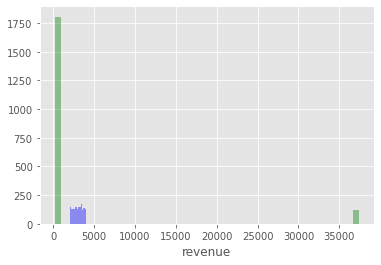

In [13]:
sns.distplot(control[control.revenue > 0].revenue, kde=False, color="g")
sns.distplot(test[test.revenue > 0].revenue, kde=False, color="b")

В контрольной группе наблюдаются выбросы. Посчитаем количество пользователей, совершивших большие покупки в контрольной группе

In [14]:
#Отфильтруем данные
big = df.query('testgroup == "a" and revenue > 10000').shape[0]
all = df.query('testgroup == "a" and revenue > 0').shape[0]
print(f"Количество пользователей, совершивших самые крупные покупки в контрольной группе: {big} \n\
Количество всех пользователей, совершивших покупку в контрольной группе: {all}")

Количество пользователей, совершивших самые крупные покупки в контрольной группе: 123 
Количество всех пользователей, совершивших покупку в контрольной группе: 1928


Как можно видеть 123 пользователя в контрольной группе делают основную выручку

Проверим данные на гомогенность дисперсий в группах. Проведем тест Левена

In [15]:
levene = pg.homoscedasticity(df, dv='revenue', group='testgroup', method='levene', alpha=0.05)
levene

,W,pval,equal_var
levene,0.389629,0.532495,True


p-value > 0.05, не отклоняем нулевую гипотезу о равенстве дисперсий. \
Теперь проверим, что данные распределены нормально. Перед применением сделаем семплирование.

In [16]:
df_sample = df.sample(1000, random_state=17)
pg.normality(df_sample, dv='revenue', group='testgroup')

,W,pval,normal
b,0.089918,8.267661e-44,False
a,0.063115,2.340168e-43,False


Распределение в группах не является нормальным, поэтому далее применяем u-test Манна-Уитни

In [17]:
ss.mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value > 0.05, не отклоняем нулевую гипотезу о равенстве распределений. По результатам примененных тестов, можно сделать вывод, что значимых статистических различий нет

Используем bootstrap для проверки

In [18]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

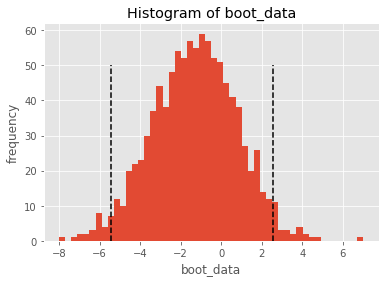

Результат bootstrap-теста:
p-value: 0.53


,0
0.025,-5.422377
0.975,2.543457


In [19]:
#Визуализируем bootstrap
booted_data = get_bootstrap(control.revenue, test.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data ["p_value"]:.2f}')
booted_data ["ci"]

Из результата видно, что p-value > 0.05 и 0 попадает в доверительный интервал. Это означает, что значимых статистических различий нет

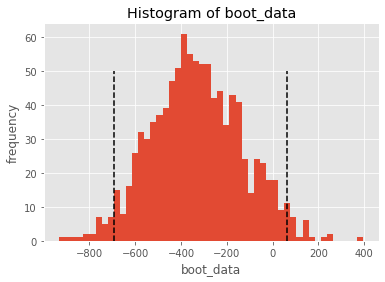

Результат bootstrap-теста:
p-value: 0.10


,0
0.025,-694.631470
0.975,61.228773


In [20]:
booted_data_revenue = get_bootstrap(c.revenue, t.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data_revenue["p_value"]:.2f}')
booted_data_revenue["ci"]

Аналогично предыдущему результату

Нет статистически значимых различий в ARPU, ARPPU в контрольной и тестовой группе. При этом конверсия в контрольной группе выше. Но в контрольной группе присутствуют аномально большие чеки. Это, конечно, может быть целевое влияние акции.

Для полного понимания предлагаю провести анализ, исключив выбросы

In [21]:
control_clear = control.query('revenue < 5000')
control_clear_value = control_clear.query("revenue > 0")

In [22]:
arpu_control = round(control_clear.revenue.sum() / control_clear.revenue.count(), 2)
arpu_test = round(test.revenue.sum() / test.revenue.count(), 2)
diff_arpu = round((arpu_test-arpu_control) / arpu_test *100, 2)
print(f'arpu_control: {arpu_control}', 
      f'arpu_test: {arpu_test}',
      f'diff_arpu: {diff_arpu}%')

arpu_control: 2.7 arpu_test: 26.75 diff_arpu: 89.91%


In [23]:
ss.mannwhitneyu(control_clear_value.revenue, test.revenue)

MannwhitneyuResult(statistic=362555910.0, pvalue=0.0)

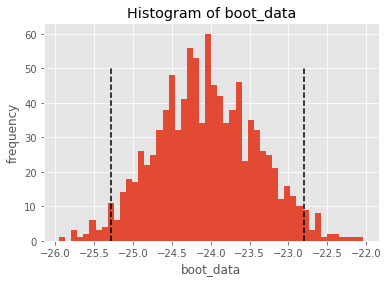

Результат bootstrap-теста:
p-value: 0.00


,0
0.025,-25.283891
0.975,-22.801787


In [24]:
booted_data_clear = get_bootstrap(control_clear.revenue, test.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data_clear["p_value"]:.2f}')
booted_data_clear["ci"]

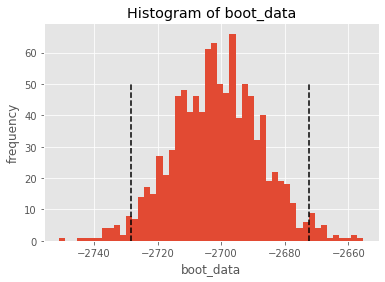

Результат bootstrap-теста:
p-value: 0.00


,0
0.025,-2728.269321
0.975,-2672.253089


In [25]:
booted_data_revenue_clear = get_bootstrap(control_clear_value.revenue, t.revenue)
print('Результат bootstrap-теста:')
print(f'p-value: {booted_data_revenue_clear["p_value"]:.2f}')
booted_data_revenue_clear["ci"]

Исключив предположительные выбросы, получаем  p-value < 0.05. Что говорит о том, что различия между группами стат.значимы.

**Итог** \
Контрольная группа имеет 123 клиента из 1928, которые совершили аномально большие покупки, что выравнивает метрики ARPU и ARPPU между контрольной и тестовой группой (нет стат.значимых различий). Отбросив аномальных клиентов, мы выяснили, что группы отличаются между собой, ARPU тестовой группы больше почти на 90%. 

Поэтому, если акционный набор контрольной группы был нацелен на привлечение больших чеков малой группой, то оставляем контрольную группу, так как она имеет большую конверсию. Если же это аномалия, то оставляем тестовую.